# Overview

This notebook is for testing Deep Learning approaches to the digits classification task.

In [1]:
%load_ext autoreload

%autoreload 2

g_seed = 10
import numpy as np
np.random.seed(g_seed)

from sklearn import datasets, model_selection, preprocessing, metrics
import pandas

from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import backend
from scipy import stats

import matplotlib.pyplot as plt

%matplotlib inline

# Load Dataset

In [2]:
data = datasets.load_digits()
tgt_encoder = preprocessing.LabelBinarizer(neg_label=-1)
data['target_bin'] = tgt_encoder.fit_transform(data.target)

## Plot Some Examples

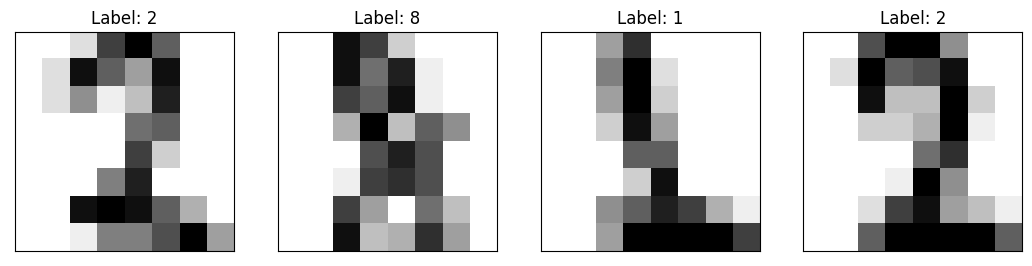

In [3]:
nshow = 4
fig = plt.figure(1, figsize=(nshow*3+1, 3))
for i in range(nshow):
    ax = fig.add_subplot(1,nshow,i+1)
    irnd = np.random.randint(data.images.shape[0])
    ax.imshow(data.images[irnd], cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Label: %i'%(data.target_names[data.target[irnd]]))
    ax.set_xticks([])
    ax.set_yticks([])

# Descriptive Analysis

Text(0, 0.5, 'Count')

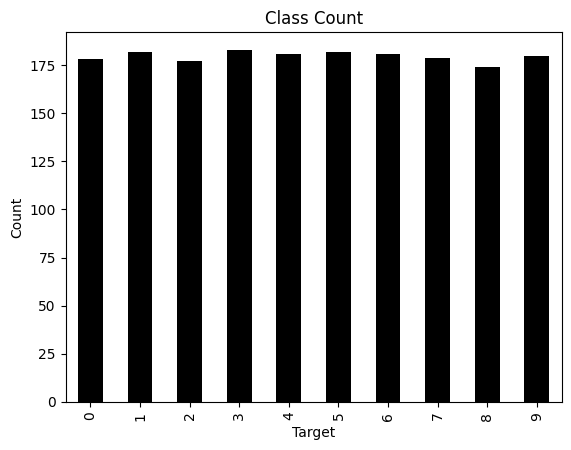

In [4]:
df = pandas.DataFrame().from_dict({'Target':data.target_names[data.target]})
df.groupby('Target').Target.count().plot(kind='bar', title='Class Count', facecolor='k')
plt.ylabel('Count')

## Train x Test Split

In [9]:
nperc = 0.8
nfold  = 10

cv = model_selection.StratifiedShuffleSplit(n_splits=1, train_size=nperc,
                                            random_state=g_seed)
for itrn, itst in cv.split(data.data, data.target):
    break
x_trn = data.data[itrn]
y_trn = data.target_bin[itrn]
c_trn = data.target[itrn]
x_tst = data.data[itst]
y_tst = data.target_bin[itst]
c_tst = data.target[itst]
print('Train Size: ', x_trn.shape[0])
print('Test  Size: ', x_tst.shape[0])

kfold = model_selection.StratifiedShuffleSplit(n_splits=nfold, random_state=g_seed)

Train Size:  1437
Test  Size:  360


## Scaling

In [10]:
scaler = preprocessing.StandardScaler().fit(x_trn)
x_trn = scaler.transform(x_trn)
x_tst = scaler.transform(x_tst)

# Modeling a Standard Neural Network

## Configuration

In [11]:
nhidden = 20
nepoch  = 100
lr = 0.01
beta_1=0.9
beta_2=0.999
epsilon=1e-08

In [12]:
net_results = []
net_model = None
net_model_result = None
best_perf = 1e9
print('Training', end='', flush=True)
for itrn, ival in kfold.split(x_trn, c_trn):
    print('.', end='', flush=True)
    model = models.Sequential()
    # Create network structure
    model.add(layers.Dense(nhidden,
                           activation = 'tanh',
                           input_shape = [x_trn.shape[1]],
                           kernel_initializer = 'uniform'))
    model.add(layers.Dense(y_trn.shape[1],
                           activation = 'tanh',
                           input_shape = [nhidden],
                           kernel_initializer = 'uniform'))
    # Training
    model.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr=lr,
                                                                       beta_1=beta_1,
                                                                       beta_2=beta_2,
                                                                       epsilon=epsilon))
    trn_desc = model.fit(x_trn[itrn], y_trn[itrn], validation_data=(x_trn[ival], y_trn[ival]),
                         epochs = nepoch, batch_size = len(itrn), verbose=0)
    net_results.append([trn_desc.history['loss'][-1], trn_desc.history['val_loss'][-1]])
    # Get best
    if trn_desc.history['val_loss'][-1] < best_perf:
        best_perf = trn_desc.history['val_loss'][-1]
        net_model = model
        net_model_result = trn_desc
net_results = np.array(net_results)        
print(' done', end='', flush=True)

Training.

c:\users\bz241wx\.virtualenvs\experimentos\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


......... done

## Results

In [18]:
yhat_trn = model.predict(x_trn)


45/45 [==============================] - 0s 1ms/step


In [21]:
yhat_trn.argmax(axis=1).shape

(1437,)

12/12 [==============================] - 0s 111us/step
Train Performance: 98.48 %
Test  Performance: 95.00 %


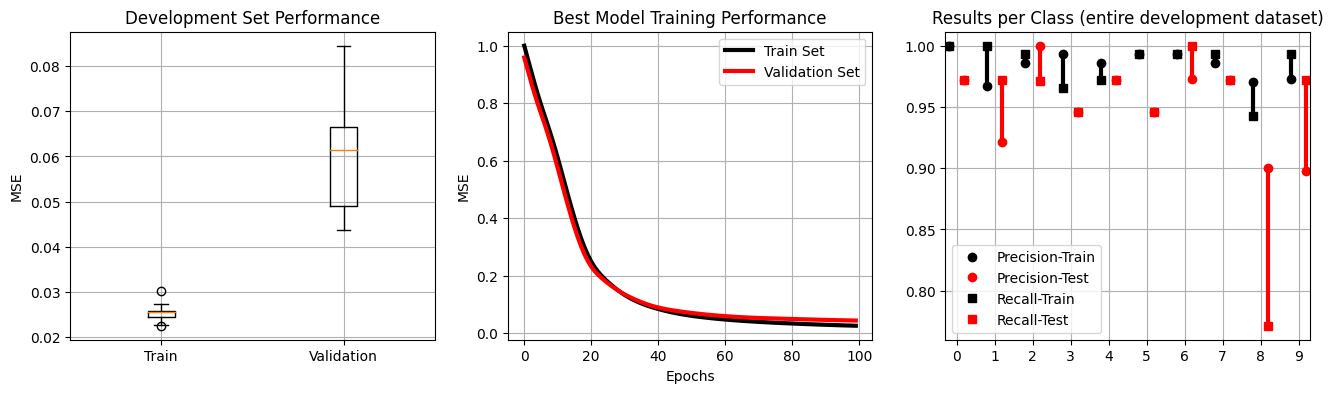

In [22]:
model = net_model
model_result = net_model_result
results = net_results

plt.figure(figsize=(16,4))

# Overall Train and Validation CV Performance
plt.subplot(1,3,1)
plt.boxplot(results)
plt.title('Development Set Performance')
plt.ylabel('MSE')
plt.xticks([1,2], ['Train', 'Validation'])
plt.grid()

# Epochs
plt.subplot(1,3,2)
plt.plot(model_result.history['loss'], 'k', lw=3, label='Train Set')
plt.plot(model_result.history['val_loss'], 'r', lw=3, label='Validation Set')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(loc='best')
plt.title('Best Model Training Performance')
plt.grid()

# Best CV Model
plt.subplot(1,3,3)
c_hat = model.predict(x_trn).argmax(axis=1)
c_hat_tst = model.predict(x_tst).argmax(axis=1)
trn_precision = metrics.precision_score(c_trn, c_hat, average=None)
trn_recall    = metrics.recall_score(c_trn, c_hat, average=None)
tst_precision = metrics.precision_score(c_tst, c_hat_tst, average=None)
tst_recall    = metrics.recall_score(c_tst, c_hat_tst, average=None)

spacer = 0.2
# precision
plt.plot(np.unique(c_trn)-spacer, trn_precision, 'ok', label='Precision-Train')
plt.plot(np.unique(c_tst)+spacer, tst_precision, 'or', label='Precision-Test')

plt.plot(np.unique(c_trn)-spacer, trn_recall, 'sk', label='Recall-Train')
plt.plot(np.unique(c_tst)+spacer, tst_recall, 'sr', label='Recall-Test')

for x,ymin,ymax in zip(np.unique(c_trn), trn_precision, trn_recall):
    plt.vlines(x=x-spacer, color='k',linestyle='-',linewidth=3,
                ymax = (ymax if ymax > ymin else ymin),
                ymin = (ymin if ymax > ymin else ymax))
for x,ymin,ymax in zip(np.unique(c_tst), tst_precision, tst_recall):
    plt.vlines(x=x+spacer, color='r',linestyle='-',linewidth=3,
                ymax = (ymax if ymax > ymin else ymin),
                ymin = (ymin if ymax > ymin else ymax))    
plt.grid()
plt.legend(loc='best', numpoints=1)
plt.xlim((np.min(c_trn)-spacer - 0.1, np.max(c_trn) + spacer + 0.1))
plt.gca().set_xticks(np.unique(c_trn))
plt.title('Results per Class (entire development dataset)')

# Some prints
print('Train Performance: %.2f %%'%(metrics.precision_score(c_trn, c_hat, average='weighted') * 100))
print('Test  Performance: %.2f %%'%(metrics.precision_score(c_tst, c_hat_tst, average='weighted') * 100))

# Modeling a Simple Deep Learning Network

In [26]:
nhiddens = [100, 50, 20]
nepoch  = 50
lr = 0.01
beta_1=0.9
beta_2=0.999
epsilon=1e-08
nfold  = 10

In [27]:
simple_dl_results = []
simple_dl_model = None
simple_dl_model_result = None
best_perf = 1e9
print('Training', end='', flush=True)
for itrn, ival in kfold.split(x_trn, c_trn):
    print('.', end='', flush=True)
    model = models.Sequential()
    ninput = x_trn.shape[1]
    # Create network structure
    for nhidden in nhiddens:
        model.add(layers.Dense(nhidden,
                               activation = 'tanh',
                               input_shape = [ninput],
                               kernel_initializer = 'uniform'))
        ninput = nhidden
    # Output layer
    model.add(layers.Dense(y_trn.shape[1],
                           activation = 'tanh',
                           input_shape = [ninput],
                           kernel_initializer = 'uniform'))
    # Training
    model.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr=lr,
                                                                       beta_1=beta_1,
                                                                       beta_2=beta_2,
                                                                       epsilon=epsilon))
    trn_desc = model.fit(x_trn[itrn], y_trn[itrn], validation_data=(x_trn[ival], y_trn[ival]),
                         epochs = nepoch, batch_size = len(itrn), verbose=0)
    simple_dl_results.append([trn_desc.history['loss'][-1], trn_desc.history['val_loss'][-1]])
    # Get best
    if trn_desc.history['val_loss'][-1] < best_perf:
        best_perf = trn_desc.history['val_loss'][-1]
        simple_dl_model = model
        simple_dl_model_result = trn_desc
simple_dl_results = np.array(simple_dl_results)        
print(' done', end='', flush=True)

Training.

c:\users\bz241wx\.virtualenvs\experimentos\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


......... done

## Results

12/12 [==============================] - 0s 1ms/step
Train Performance: 96.57 %
Test  Performance: 94.08 %


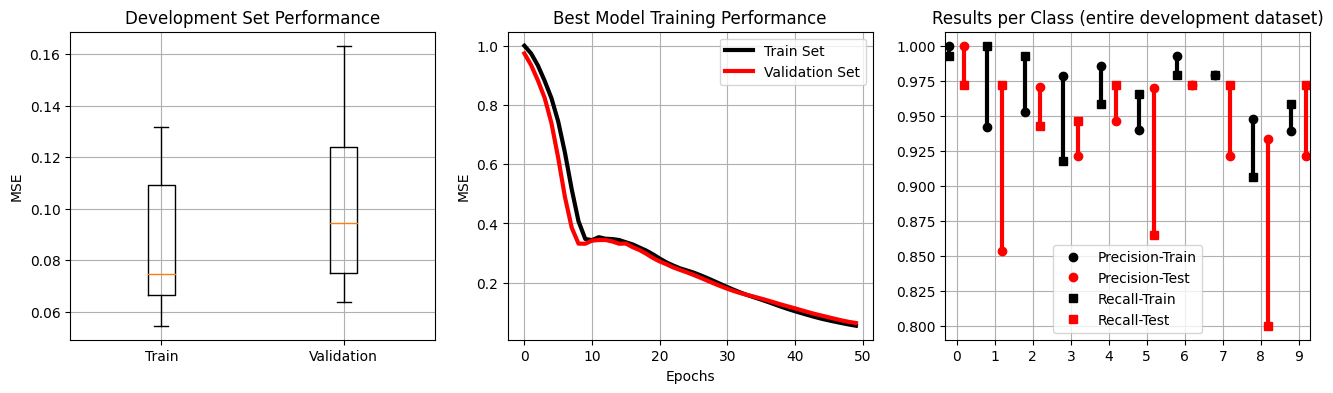

In [28]:
model = simple_dl_model
model_result = simple_dl_model_result
results = simple_dl_results

plt.figure(figsize=(16,4))

# Overall Train and Validation CV Performance
plt.subplot(1,3,1)
plt.boxplot(results)
plt.title('Development Set Performance')
plt.ylabel('MSE')
plt.xticks([1,2], ['Train', 'Validation'])
plt.grid()

# Epochs
plt.subplot(1,3,2)
plt.plot(model_result.history['loss'], 'k', lw=3, label='Train Set')
plt.plot(model_result.history['val_loss'], 'r', lw=3, label='Validation Set')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(loc='best')
plt.title('Best Model Training Performance')
plt.grid()

# Best CV Model
plt.subplot(1,3,3)
c_hat = model.predict(x_trn).argmax(axis=1)
c_hat_tst = model.predict(x_tst).argmax(axis=1)
trn_precision = metrics.precision_score(c_trn, c_hat, average=None)
trn_recall    = metrics.recall_score(c_trn, c_hat, average=None)
tst_precision = metrics.precision_score(c_tst, c_hat_tst, average=None)
tst_recall    = metrics.recall_score(c_tst, c_hat_tst, average=None)

spacer = 0.2
# precision
plt.plot(np.unique(c_trn)-spacer, trn_precision, 'ok', label='Precision-Train')
plt.plot(np.unique(c_tst)+spacer, tst_precision, 'or', label='Precision-Test')

plt.plot(np.unique(c_trn)-spacer, trn_recall, 'sk', label='Recall-Train')
plt.plot(np.unique(c_tst)+spacer, tst_recall, 'sr', label='Recall-Test')

for x,ymin,ymax in zip(np.unique(c_trn), trn_precision, trn_recall):
    plt.vlines(x=x-spacer, color='k',linestyle='-',linewidth=3,
                ymax = (ymax if ymax > ymin else ymin),
                ymin = (ymin if ymax > ymin else ymax))
for x,ymin,ymax in zip(np.unique(c_tst), tst_precision, tst_recall):
    plt.vlines(x=x+spacer, color='r',linestyle='-',linewidth=3,
                ymax = (ymax if ymax > ymin else ymin),
                ymin = (ymin if ymax > ymin else ymax))    
plt.grid()
plt.legend(loc='best', numpoints=1)
plt.xlim((np.min(c_trn)-spacer - 0.1, np.max(c_trn) + spacer + 0.1))
plt.gca().set_xticks(np.unique(c_trn))
plt.title('Results per Class (entire development dataset)')

# Some prints
print('Train Performance: %.2f %%'%(metrics.precision_score(c_trn, c_hat, average='weighted') * 100))
print('Test  Performance: %.2f %%'%(metrics.precision_score(c_tst, c_hat_tst, average='weighted') * 100))

# Modeling a Stacked Auto Encoder

## Configuration

In [30]:
import sys
sys.path.append('../DeepLearning/')

import StackedAutoEncoder as SAE

net_config = {
    'hiddens': [x_trn.shape[1], 10, 5, 2, 5, 10, x_trn.shape[1]],
    'optimizers': ['adam','adam','adam'],
    'nepochs': 100,
    'batch_size': 100,
    'ninit': 1,    
    'verbose': 0,
}

## Train

In [31]:
sae_results = []
sae_model = None
sae_model_result = None
best_perf = 1e9
print('Training', end='', flush=True)
for itrn, ival in kfold.split(x_trn, c_trn):
    print('.', end='', flush=True)
    model = SAE.StackedAutoEncoder(**net_config)
    model.fit(x_trn[itrn], validation_data = x_trn[ival])
    sae_results.append([model.score(x_trn[itrn]), model.score(x_trn[ival])])
    # Get best
    if sae_results[-1][1] < best_perf:
        best_perf = sae_results[-1][1]
        sae_model = model
        sae_model_result = trn_desc
sae_results = np.array(sae_results)        
print(' done', end='', flush=True)

Training.

c:\users\bz241wx\.virtualenvs\experimentos\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


5/5 [==============================] - 0s 2ms/step
.

c:\users\bz241wx\.virtualenvs\experimentos\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


5/5 [==============================] - 0s 5ms/step
.

c:\users\bz241wx\.virtualenvs\experimentos\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


5/5 [==============================] - 0s 5ms/step
.

c:\users\bz241wx\.virtualenvs\experimentos\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


5/5 [==============================] - 0s 4ms/step
.

c:\users\bz241wx\.virtualenvs\experimentos\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


5/5 [==============================] - 0s 2ms/step
.

c:\users\bz241wx\.virtualenvs\experimentos\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


5/5 [==============================] - 0s 0s/step
.

c:\users\bz241wx\.virtualenvs\experimentos\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


5/5 [==============================] - 0s 0s/step
.

c:\users\bz241wx\.virtualenvs\experimentos\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


5/5 [==============================] - 0s 0s/step
.

c:\users\bz241wx\.virtualenvs\experimentos\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


5/5 [==============================] - 0s 0s/step
.

c:\users\bz241wx\.virtualenvs\experimentos\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


5/5 [==============================] - 0s 2ms/step
 done

## Results

45/45 [==============================] - 0s 1ms/step


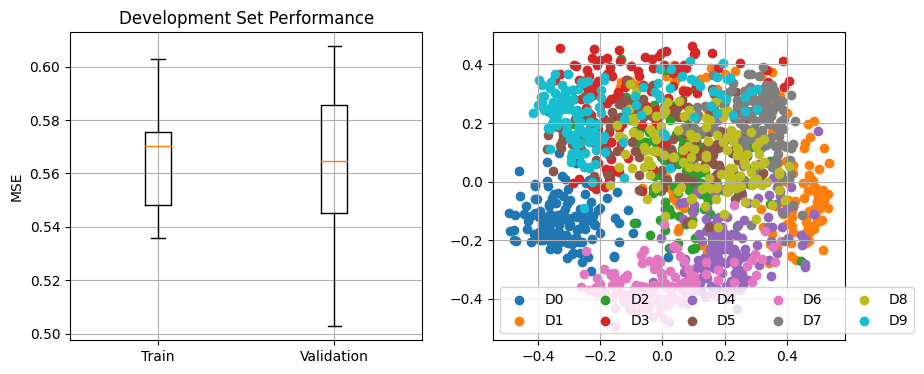

In [44]:
model = sae_model
model_result = sae_model_result
results = sae_results

plt.figure(figsize=(10,4))

# Overall Train and Validation CV Performance
plt.subplot(1,2,1)
plt.boxplot(results)
plt.title('Development Set Performance')
plt.ylabel('MSE')
plt.xticks([1,2], ['Train', 'Validation'])
plt.grid()

plt.subplot(1,2,2)
x_encoded = sae_model.encode(x_trn)
for cls in np.unique(c_trn):
    idx = c_trn == cls
    plt.scatter(x_encoded[idx,0], x_encoded[idx,1], label=f'D{cls}')
plt.grid()
plt.legend(loc='best', ncol = 5)

1/1 [==============================] - 0s 16ms/step


([], [])

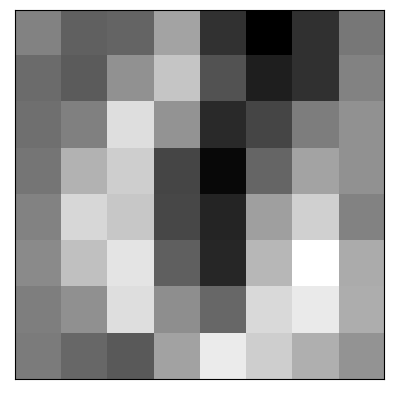

In [48]:
# x_decoded = sae_model.decode(np.array([[0.1, -0.2]])).reshape((1, 8,8))
# x_decoded = sae_model.decode(np.array([[-0.312, -0.112]])).reshape((1, 8,8))
x_decoded = sae_model.decode(np.array([[0.4, 0.4]])).reshape((1, 8,8))

plt.imshow(x_decoded[0], cmap=plt.cm.gray_r, interpolation='nearest')
#plt.title('Label: %i'%(data.target_names[data.target[irnd]]))
plt.xticks([])
plt.yticks([])